In [1]:
#################################################
#created the 02/052018 14:27 by Alexis Blanchet#
#################################################
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import scipy.stats
import matplotlib
import plotly.offline as offline
import plotly.graph_objs as go
from sklearn.cluster import SpectralClustering
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from scipy import stats
from sklearn.metrics import log_loss
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
df = pd.read_csv('/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20180430_0_192_0_cleandata-processed.csv')

In [3]:
y = pd.read_csv('/home/alexis/Bureau/Stage/Time-series/y_true.csv').drop(['Unnamed: 0'],axis = 1)
y.head()

,CP
0,0
1,0
2,0
3,0
4,0


In [4]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(1)

In [5]:
res = [398,409,428,441,455,468,487,494,518,523,568,585,634,642,652,657,676,711,748,778,828,850,827,849,859,893,896,897,915,936,960,981,1008,1048,1049,1060,1061,1067,1071,1078,1079,1086,1087,1120,1155,1156,1187,1188,1189,1190,1215,1250,1278,1290,1305,1333,1344,1368,1380]

In [6]:
for i in res:
    y['CP'][i+3] = 1
y.to_csv('/home/alexis/Bureau/Stage/Time-series/y_true2.csv',index=False)

In [7]:
def plot_annomalies(df,anomalies):
    """
    prend en entrée le nombres d'indicateurs qui detectent une annomalie
    ainsi que le datafame contenant tous les features(on a effacé 3 lignes)
    renvoie un graph présentant les zones d'incertitudes quand a la présence
    d'un événement important dans la plage horaire
    en vert une montée d'audience, en orange une baisse d'audiance
    """
    anomalies = list(anomalies)
    l1 = find_index(anomalies,0)
    l2 = find_index(anomalies,-1)
    l3 = find_index(anomalies,1)

    x = df['t'].values
    t= [i for i in range(len(x))]
    x1 = [t[i] for i in l1]
    x2 = [t[i] for i in l2]
    x3 = [t[i] for i in l3]
    y1 = [x[i] for i in l1]
    y2 = [x[i] for i in l2]
    y3 = [x[i] for i in l3]

    
    trace1 = go.Scatter(
        x=x1,
        y=y1,
        mode = 'markers',
        name = 'regular',
    
    )
    trace2 = go.Scatter(
        x=x2,
        y=y2,
        mode = 'markers',
        name ='anormal loss',
    )
    trace3 = go.Scatter(
        x=x3,
        y=y3,
        mode = 'markers',
        name = 'anormal gain',
    )
    trace4 = go.Scatter(
        x=0,
        y=0,
        mode = 'markers',
        name = 'begin of programmes',
    )
        
    fig = tools.make_subplots(rows=4, cols=1, specs=[[{}], [{}], [{}], [{}]],
                              shared_xaxes=True, shared_yaxes=True,
                              vertical_spacing=0.001)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace3, 1, 1)
    fig.append_trace(trace4, 1, 1)

    fig['layout'].update(height=3000, width=2000, title='Annomalie detection')
    plot(fig, filename='data.html')

def find_index(l,v):
    res = []
    for i, j in enumerate(l):
        if(j == v):
            res.append(i)
    return res    

In [8]:
plot_annomalies(df,y['CP'][3:])

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]



In [9]:
df.shape

(1437, 28)

In [10]:
y['CP'].shape

(1440,)

In [11]:
y_pred = df['label']

In [11]:
X = df.values
y = y['CP'][3:].values

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
dataset = df
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
Y = y.reshape(-1, 1)
scalery = MinMaxScaler(feature_range=(0, 1))
Y = scalery.fit_transform(Y)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
trainX, testX = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
trainY, testY = Y[0:train_size], Y[train_size:len(dataset)]
print(len(trainX), len(testX))

962 475


In [13]:
#Some functions and losses for the algorithms

def logloss_lgbm(preds, dtrain):
    labels = dtrain.get_label()
    score = 1-log_loss(labels, preds)
    return 'logloss', score,True

def logloss_xgb(preds, dtrain):
    labels = dtrain.get_label()
    score = log_loss(labels, preds)
    return 'logloss', score


In [14]:
######################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
######################################################
### XGB modeling
params = {'eta': 0.02,
          'max_depth': 20, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':1,
          'alpha':2,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False}
params2 = {'eta': 0.02,
          'max_depth': 15, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':1,
          'alpha':1,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False}
######################################################
class Classifier(BaseEstimator):
    def __init__(self):
        pass
 
    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
        self.clf1 = xgb.train(params, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=300)
        self.clf2 = xgb.train(params2, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=300)
        
       
    def predict(self, X):
        return self.clf.predict(X)
 
    def predict_proba(self, X):
        res1 = self.clf1.predict(xgb.DMatrix(X), ntree_limit=self.clf1.best_ntree_limit)
        res2 = self.clf2.predict(xgb.DMatrix(X), ntree_limit=self.clf2.best_ntree_limit)
        res = [(r1+r2)*0.5 for r1,r2 in zip(res1,res2)]
        return np.array([ [1-c,c] for c in res])
clf = Classifier()
clf.fit(trainX,trainY)

[0]	train-logloss:0.676617	valid-logloss:0.676971
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 300 rounds.
[100]	train-logloss:0.15843	valid-logloss:0.180351
[200]	train-logloss:0.081714	valid-logloss:0.117231
[300]	train-logloss:0.0599	valid-logloss:0.106123
[400]	train-logloss:0.050188	valid-logloss:0.104761
[500]	train-logloss:0.044546	valid-logloss:0.10384
[600]	train-logloss:0.041615	valid-logloss:0.103928
[700]	train-logloss:0.039141	valid-logloss:0.103672
[800]	train-logloss:0.037714	valid-logloss:0.103735
[900]	train-logloss:0.036577	valid-logloss:0.104009
[1000]	train-logloss:0.035652	valid-logloss:0.10411
Stopping. Best iteration:
[713]	train-logloss:0.038913	valid-logloss:0.10359

[0]	train-logloss:0.676299	valid-logloss:0.67717
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 300 rounds.
[10

In [17]:
######################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import lightgbm as lgb
######################################################


### LGB modeling
params = {'learning_rate': 0.0015,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 0.0,
          'reg_lambda': 0,
          'max_depth' : 6,
          'num_leaves': 10,        
          'min_data_in_leaf': 1, 
          'boosting': 'goss',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}

params1 = {'learning_rate': 0.0015,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 0.0,
          'reg_lambda': 0,
          'max_depth' : 7,
          'num_leaves': 10,        
          'min_data_in_leaf': 1, 
          'boosting': 'goss',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}
MAX_TREES = 5000

class Classifier1(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=99)
        watchlist = [(lgb.Dataset(x1, label=y1), 'train'), (lgb.Dataset(x2, label=y2), 'valid')]
        self.clf2 = lgb.train(params, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=100, feval=logloss_lgbm, early_stopping_rounds=300)
        self.clf1 = lgb.train(params1, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=100, feval=logloss_lgbm, early_stopping_rounds=300)
    def predict(self, X):
        return self.clf1.predict(X)

    def predict_proba(self, X):
        res1 = self.clf1.predict(X, num_iteration = self.clf1.best_iteration)
        res2 = self.clf2.predict(X,num_iteration = self.clf2.best_iteration)
        return np.array([[1-0.5*(a+b),0.5*(a+b)] for a,b in zip(res1,res2)])
        
    
classifier1 = Classifier1()
classifier1.fit(trainX,[y[0] for y in trainY])

Training until validation scores don't improve for 300 rounds.
[100]	valid_0's binary_logloss: 0.579435	valid_0's logloss: 0.420565
[200]	valid_0's binary_logloss: 0.492978	valid_0's logloss: 0.507022
[300]	valid_0's binary_logloss: 0.423957	valid_0's logloss: 0.576043
[400]	valid_0's binary_logloss: 0.366637	valid_0's logloss: 0.633363
[500]	valid_0's binary_logloss: 0.321804	valid_0's logloss: 0.678196
[600]	valid_0's binary_logloss: 0.284904	valid_0's logloss: 0.715096
[700]	valid_0's binary_logloss: 0.254648	valid_0's logloss: 0.745352
[800]	valid_0's binary_logloss: 0.230523	valid_0's logloss: 0.769477
[900]	valid_0's binary_logloss: 0.210173	valid_0's logloss: 0.789827
[1000]	valid_0's binary_logloss: 0.192377	valid_0's logloss: 0.807623
[1100]	valid_0's binary_logloss: 0.177546	valid_0's logloss: 0.822454
[1200]	valid_0's binary_logloss: 0.165399	valid_0's logloss: 0.834601
[1300]	valid_0's binary_logloss: 0.154896	valid_0's logloss: 0.845104
[1400]	valid_0's binary_logloss: 0.1

In [19]:
from sklearn.base import BaseEstimator
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

class Classifier3(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=99)
        self.clf1 = CatBoostClassifier(iterations=2000,learning_rate=0.01, depth=7,metric_period = 50, loss_function='Logloss', eval_metric='Logloss', random_seed=99, od_type='Iter', od_wait=100)
        self.clf1.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
        self.clf2 = CatBoostClassifier(iterations=2000,learning_rate=0.01, depth=8,metric_period = 50, loss_function='Logloss', eval_metric='Logloss', random_seed=99, od_type='Iter', od_wait=100)
        self.clf2.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return np.array([[0,(v[1]+l[1])*0.5] for v,l in zip(self.clf2.predict_proba(X),self.clf1.predict_proba(X))])
classifier3 = Classifier3()
classifier3.fit(trainX,[y[0] for y in trainY])

0:	learn: 0.6770226	test: 0.6775017	best: 0.6775017 (0)	total: 66.3ms	remaining: 2m 12s
50:	learn: 0.2654680	test: 0.2709226	best: 0.2709226 (50)	total: 398ms	remaining: 15.2s
100:	learn: 0.1581734	test: 0.1710420	best: 0.1710420 (100)	total: 725ms	remaining: 13.6s
150:	learn: 0.1198262	test: 0.1402540	best: 0.1402540 (150)	total: 1.06s	remaining: 12.9s
200:	learn: 0.0994268	test: 0.1279633	best: 0.1279470 (199)	total: 1.38s	remaining: 12.4s
250:	learn: 0.0831238	test: 0.1212821	best: 0.1212694 (249)	total: 1.72s	remaining: 12s
300:	learn: 0.0724177	test: 0.1173469	best: 0.1173469 (300)	total: 2.04s	remaining: 11.5s
350:	learn: 0.0629343	test: 0.1155949	best: 0.1155949 (350)	total: 2.41s	remaining: 11.3s
400:	learn: 0.0548245	test: 0.1140066	best: 0.1140066 (400)	total: 2.82s	remaining: 11.2s
450:	learn: 0.0485562	test: 0.1131710	best: 0.1129757 (445)	total: 3.15s	remaining: 10.8s
500:	learn: 0.0426865	test: 0.1127149	best: 0.1126613 (479)	total: 3.48s	remaining: 10.4s
550:	learn: 0.03

In [20]:
X_test = testX
y1,y2,y3 = clf.predict_proba(X_test),classifier1.predict_proba(X_test),classifier3.predict_proba(X_test)


In [22]:
X_test = trainX
y1,y2,y3 = clf.predict_proba(X_test),classifier1.predict_proba(X_test),classifier3.predict_proba(X_test)

trainPredict = []
for i in range(y1.shape[0]):
    r = (y1[i][1]+y2[i][1]+y3[i][1])/3
    if(r>0.15):
        trainPredict.append(1)
    else:
        trainPredict.append(0)

In [23]:
X_test = testX
y1,y2,y3 = clf.predict_proba(X_test),classifier1.predict_proba(X_test),classifier3.predict_proba(X_test)
testPredict = []
for i in range(y1.shape[0]):
    r = (y1[i][1]+y2[i][1]+y3[i][1])/3
    if(r>0.15):
        testPredict.append(1)
    else:
        testPredict.append(0)

In [25]:
x = df['t'].values
t= [i for i in range(len(x))]


l1 = find_index(trainPredict,1)
l2 = find_index(testPredict,1)

x1 = [t[i] for i in l1]
x2 = [t[i+train_size] for i in l2]

y1 = [x[i] for i in l1]
y2 = [x[i+train_size] for i in l2]

l3 = find_index(y,1)
print(l3)
x3 = [t[i] for i in l3]
y3 = [x[i] for i in l3]


trace1 = go.Scatter(
        x= t,
        y= x,
        name = 'true',
    
)
trace2 = go.Scatter(
        x =x1,
        y=y1,
        mode = 'markers',
        name ='train',
)
trace3 = go.Scatter(
        x=x2,
        y= y2,
        mode = 'markers',
        name = 'test',
)
trace4 = go.Scatter(
        x=x3,
        y=y3,
        mode = 'markers',
        name = 'true events',
)
        
fig = tools.make_subplots(rows=4, cols=1, specs=[[{}], [{}], [{}], [{}]],
                              shared_xaxes=True, shared_yaxes=True,
                              vertical_spacing=0.001)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace3, 1, 1)
fig.append_trace(trace4, 1, 1)

fig['layout'].update(height=3000, width=2000, title='Annomalie detection')
plot(fig, filename='data.html')


[398, 409, 413, 428, 429, 441, 442, 454, 455, 456, 468, 469, 487, 494, 497, 518, 523, 529, 535, 568, 585, 588, 591, 595, 634, 642, 652, 656, 657, 676, 682, 711, 748, 757, 778, 784, 827, 828, 833, 849, 850, 859, 861, 869, 893, 896, 897, 915, 936, 960, 981, 1008, 1048, 1049, 1060, 1061, 1067, 1071, 1078, 1079, 1086, 1087, 1120, 1155, 1156, 1187, 1188, 1189, 1190, 1215, 1250, 1278, 1290, 1305, 1333, 1344, 1368, 1380]
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]



'file:///home/alexis/Bureau/Stage/ML/data.html'

In [20]:
df2 = pd.read_csv('/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20171215_0_192_0_cleandata-processed.csv')
y2 = pd.read_csv('/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20171215_0_192_0_cleandata-y.csv')

In [21]:
df2 = df2.drop(['label'],axis=1).fillna(1)
df2.head()

,t-3,t-2,t-1,t,minutes,diff t t-1,diff t t-2,diff t t-3,diff t-1 t-2,diff t-1 t-3,...,diff pente 1-3,diff pentes,diff pente 2-3,GP,covariance,pics,KDFR,probability,distribution,skewness
0,3861826.0,3919113.0,3930969.0,3908951,3,-22018.0,-10162.0,47125.0,11856.0,69143.0,...,3.601826,-2.063357,-3.831899,0.999968,6.882465e+08,1,1.500000,1.941902e-10,0.499963,5.644233e-32
1,3919113.0,3930969.0,3908951.0,3849858,4,-59093.0,-81111.0,-69255.0,-22018.0,-10162.0,...,1.200633,-0.573232,1.538469,0.999764,9.747410e+08,0,0.021532,1.941902e-10,0.499956,1.162822e-31
2,3930969.0,3908951.0,3849858.0,3861348,5,11490.0,-47603.0,-69621.0,-59093.0,-81111.0,...,2.916275,3.226719,0.627401,0.999991,1.112557e+09,-1,0.399655,1.941902e-10,0.499969,8.752554e-32
3,3908951.0,3849858.0,3861348.0,3979121,6,117773.0,129263.0,70170.0,11490.0,-47603.0,...,1.501753,-0.599314,6.142994,0.999124,2.587080e+09,0,0.156679,1.941902e-10,0.499990,6.733439e-31
4,3849858.0,3861348.0,3979121.0,3979017,7,-104.0,117669.0,129159.0,117773.0,129263.0,...,111.480769,50.000000,0.902439,1.000000,3.827467e+09,1,0.191332,1.941902e-10,0.499967,8.365564e-31


In [22]:
X_test = df2.values

In [23]:
def sum_list(a,b):
    c = [x+y for x,y in zip(a,b)]
    return c
res = classifier1.predict_proba(X_test)

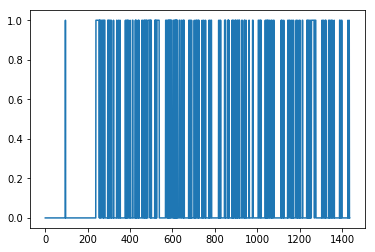

In [24]:
cl = [ 1 if l[1]>0.05 else 0 for l in res]
plt.plot(cl)

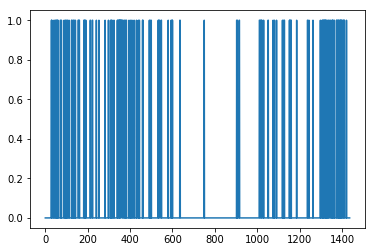

In [25]:
plt.plot(abs(y2))

In [30]:
import pickle
classifier3.clf1.save_model("model1")
classifier3.clf2.save_model("model2")
pickle.dump(classifier1.clf1, open("pima.pickle.dat", "wb"))
pickle.dump(classifier1.clf2, open("pima2.pickle.dat", "wb"))

In [27]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

def fi(gb,name):
    trace = go.Scatter(
        y = gb.feature_importances_,
        x = features,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 13,
            #size= rf.feature_importances_,
            #color = np.random.randn(500), #set color equal to a variable
            color = gb.feature_importances_,
            colorscale='Portland',
            showscale=True
        ),
        text = features
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= name+' Feature Importance',
        hovermode= 'closest',
         xaxis= dict(
             ticklen= 5,
             showgrid=False,
            zeroline=False,
            showline=False
         ),
        yaxis=dict(
            title= 'Feature Importance',
            showgrid=False,
            zeroline=False,
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    plot(fig, filename='scatter2010')
    


In [28]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_leaf=2, max_features=27, n_jobs=-1, random_state=0)
rf.fit(trainX,[y[0] for y in trainY])
features = df.columns.values
print("----- Training Done -----Printing Score")
print(rf.score(trainX,[y[0] for y in trainY]))
# Scatter plot 
fi(rf,'Random Forest')

----- Training Done -----Printing Score
0.989604989605


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=150, max_depth=20, min_samples_leaf=1, max_features=27, random_state=0)
gb.fit(trainX,[y[0] for y in trainY])
print("----- Training Done -----Printing Score")
print(gb.score(trainX,[y[0] for y in trainY]))
fi(gb,'Gradient Boosting Machine')

----- Training Done -----Printing Score
1.0
